In [1]:
library(tidyverse)

source("/home/joosungm/projects/def-lelliott/joosungm/projects/peak-bloom-prediction/code/F01_functions.r")
kyoto_df <- data.frame(data.table::fread("../outputs/A_outputs/A31_japan_temperature.csv"))
head(kyoto_df)
dim(kyoto_df)

station_ids <- unique(kyoto_df$id)
length(station_ids)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.3.6      ✔ purrr   0.3.4 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.4.1 
✔ readr   2.1.2      ✔ forcats 0.5.2 
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Registered S3 method overwritten by 'hoardr':
  method           from
  print.cache_info httr

Loading required package: R6


Attaching package: ‘lightgbm’


The following object is masked from ‘package:dplyr’:

    slice




,id,date,tmax,tmin,prcp,year,month,day,row_num,id_rownum
,<chr>,<date>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<chr>
1,JA000047616,1951-01-01,3.7,0.3,34.8,1951,1,1,1,JA000047616-1
2,JA000047616,1951-01-02,3.5,-1.3,3.5,1951,1,2,2,JA000047616-2
3,JA000047616,1951-01-03,4.7,-1.3,7.2,1951,1,3,3,JA000047616-3
4,JA000047616,1951-01-04,5.8,0.3,3.7,1951,1,4,4,JA000047616-4
5,JA000047616,1951-01-05,5.0,-0.3,5.8,1951,1,5,5,JA000047616-5
6,JA000047616,1951-01-06,5.4,-0.4,0.0,1951,1,6,6,JA000047616-6


[1] 253389     10

[1] 10

In [3]:
japan_list <- list()

for (st in station_ids) {
    
    temp_df <- kyoto_df[kyoto_df$id == st, ]
    temp_df$daily_Cd <- apply(temp_df, MARGIN = 1, FUN = function(x) {F01_chill_days(r = x)[1]})
    temp_df$daily_Ca <- apply(temp_df, MARGIN = 1, FUN = function(x) {F01_chill_days(r = x)[2]})
    japan_list[[st]] <- temp_df
}

japan_df1 <- japan_list %>% bind_rows()
head(japan_df1)
dim(japan_df1)

,id,date,tmax,tmin,prcp,year,month,day,row_num,id_rownum,daily_Cd,daily_Ca
,<chr>,<date>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<chr>,<dbl>,<dbl>
1,JA000047616,1951-01-01,3.7,0.3,34.8,1951,1,1,1,JA000047616-1,-1.700000,0
2,JA000047616,1951-01-02,3.5,-1.3,3.5,1951,1,2,2,JA000047616-2,-1.276042,0
3,JA000047616,1951-01-03,4.7,-1.3,7.2,1951,1,3,3,JA000047616-3,-1.840833,0
4,JA000047616,1951-01-04,5.8,0.3,3.7,1951,1,4,4,JA000047616-4,-2.750000,0
5,JA000047616,1951-01-05,5.0,-0.3,5.8,1951,1,5,5,JA000047616-5,-2.358491,0
6,JA000047616,1951-01-06,5.4,-0.4,0.0,1951,1,6,6,JA000047616-6,-2.513793,0


[1] 253389     12

In [4]:
dim(japan_df1)
head(japan_df1)
unique(japan_df1$month)

[1] 253389     12

,id,date,tmax,tmin,prcp,year,month,day,row_num,id_rownum,daily_Cd,daily_Ca
,<chr>,<date>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<chr>,<dbl>,<dbl>
1,JA000047616,1951-01-01,3.7,0.3,34.8,1951,1,1,1,JA000047616-1,-1.700000,0
2,JA000047616,1951-01-02,3.5,-1.3,3.5,1951,1,2,2,JA000047616-2,-1.276042,0
3,JA000047616,1951-01-03,4.7,-1.3,7.2,1951,1,3,3,JA000047616-3,-1.840833,0
4,JA000047616,1951-01-04,5.8,0.3,3.7,1951,1,4,4,JA000047616-4,-2.750000,0
5,JA000047616,1951-01-05,5.0,-0.3,5.8,1951,1,5,5,JA000047616-5,-2.358491,0
6,JA000047616,1951-01-06,5.4,-0.4,0.0,1951,1,6,6,JA000047616-6,-2.513793,0


[1]  1  2  3  4  5  6  7  8  9 10 11 12

In [5]:
# Obtain cumsum of Cd and Ca
# - Cd: start from (yr-1)-10-01
# - Ca: start from yr-01-31
# Merge with the bloom_date data.
# Plot histogram of the Ca_cumsum of the bloom_date.

kyoto_list <- list()
Ca_compute_month_day <- "-01-31"
years <- unique(japan_df1$year)

for (st in station_ids){
    
    for (yr in years) {
        
        # Compute Cd_cumsum from Oct 1, yr-1 
        sub_df <- japan_df1[paste0(as.character(yr-1), "-09-30") < japan_df1$date & japan_df1$date < paste0(as.character(yr), "-05-01"), ] %>%
            filter(id == !!(st))
        sub_df$Cd_cumsum <- cumsum(sub_df$daily_Cd)
        
        # Compute Ca_cumsum from Feb 1, yr
        sub_df2 <- sub_df[sub_df$date > as.Date(paste0(as.character(yr), Ca_compute_month_day)), ]
        sub_df2$Ca_cumsum <- cumsum(sub_df2$daily_Ca)
        
        combined_df <- sub_df %>% merge(y = sub_df2[, c("date", "Ca_cumsum")], by = "date", all.x = TRUE)
        combined_df$diff_Ca_Cd <- abs(combined_df$daily_Ca) - abs(combined_df$daily_Cd)
        combined_df$diff_Ca_Cd_cumsum <- cumsum(combined_df$diff_Ca_Cd)
        
        list_id <- paste0(st, "-", yr)
        kyoto_list[[list_id]] <- combined_df
    }
}

# print("done")

kyoto_complete <- kyoto_list %>% bind_rows() %>%
    filter(!is.na(Ca_cumsum))
dim(kyoto_complete)
head(kyoto_complete)
data.table::fwrite(kyoto_complete, "../outputs/A_outputs/temp/A41_kyoto_complete.csv")

[1] 62022    16

,date,id,tmax,tmin,prcp,year,month,day,row_num,id_rownum,daily_Cd,daily_Ca,Cd_cumsum,Ca_cumsum,diff_Ca_Cd,diff_Ca_Cd_cumsum
,<date>,<chr>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1951-02-01,JA000047616,9.6,-0.4,2.3,1951,2,1,32,JA000047616-32,-3.3080000,1.30,-65.79558,1.30,-2.00800000,-56.04558
2,1951-02-02,JA000047616,12.7,-1.7,7.3,1951,2,2,33,JA000047616-33,-2.7503472,2.85,-68.54592,4.15,0.09965278,-55.94592
3,1951-02-03,JA000047616,2.4,-2.2,9.8,1951,2,3,34,JA000047616-34,-0.6260870,0.00,-69.17201,4.15,-0.62608696,-56.57201
4,1951-02-04,JA000047616,2.4,-1.9,9.2,1951,2,4,35,JA000047616-35,-0.6697674,0.00,-69.84178,4.15,-0.66976744,-57.24178
5,1951-02-05,JA000047616,4.3,-4.6,4.1,1951,2,5,36,JA000047616-36,-1.0387640,0.00,-70.88054,4.15,-1.03876404,-58.28054
6,1951-02-06,JA000047616,7.9,-3.9,0.0,1951,2,6,37,JA000047616-37,-2.1944915,0.45,-73.07503,4.60,-1.74449153,-60.02503


In [6]:

unique(kyoto_complete$month)
# cherry_bloom_date

[1] 2 3 4

In [7]:
city_table <- read.csv("../outputs/A_outputs/A31_japan_station_city.csv")
city_table

X,id,name,latitude,longitude,elevation
<int>,<chr>,<chr>,<dbl>,<dbl>,<int>
1,JA000047616,FUKUI,36.050,136.217,17
2,JA000047632,GIFU,35.400,136.767,17
3,JA000047636,NAGOYA,35.167,136.967,56
4,JA000047651,TSU,34.733,136.517,18
5,JA000047746,TOTTORI,35.483,134.233,16
6,JA000047759,KYOTO,35.017,135.733,46
7,JA000047768,OKAYAMA,34.667,133.917,18
8,JA000047770,KOBE,34.700,135.217,30
9,JA000047777,WAKAYAMA,34.233,135.167,18


In [8]:
cherry_bloom_date <- read.csv("../outputs/A_outputs/A11_cherry_sub.csv") %>%
    mutate(city_upper = toupper(city)) %>%
    filter(city_upper %in% city_table$name) %>%
    dplyr::select(-location, -city) %>%
    mutate(month = as.integer(strftime(bloom_date, '%m'))) %>%
    mutate(day = as.integer(strftime(bloom_date, '%d')))

head(cherry_bloom_date)

,lat,long,alt,year,bloom_date,bloom_doy,country,city_upper,month,day
,<dbl>,<dbl>,<dbl>,<int>,<chr>,<int>,<chr>,<chr>,<int>,<int>
1,36.05556,136.2225,8.8,1953,1953-04-12,102,Japan,FUKUI,4,12
2,36.05556,136.2225,8.8,1954,1954-04-06,96,Japan,FUKUI,4,6
3,36.05556,136.2225,8.8,1955,1955-04-09,99,Japan,FUKUI,4,9
4,36.05556,136.2225,8.8,1956,1956-04-14,105,Japan,FUKUI,4,14
5,36.05556,136.2225,8.8,1957,1957-04-17,107,Japan,FUKUI,4,17
6,36.05556,136.2225,8.8,1958,1958-04-07,97,Japan,FUKUI,4,7


In [ ]:
# cherry_bloom_date %>%filter(city_upper == "KYOTO")
# head(kyoto_complete)

In [9]:
library(tidyverse)
kyoto_complete <- data.frame(data.table::fread("../outputs/A_outputs/temp/A41_kyoto_complete.csv")) %>%
    mutate(date = as.character(date))

city_table <- read.csv("../outputs/A_outputs/A31_japan_station_city.csv") %>%
    dplyr::select(id, name)

cherry_bloom_date <- read.csv("../outputs/A_outputs/A11_cherry_sub.csv") %>%
    mutate(city_upper = toupper(city)) %>%
    filter(city_upper %in% city_table$name) %>%
    dplyr::select(-location, -city)

city_loc <- cherry_bloom_date %>%
    distinct(city_upper, .keep_all = TRUE)

kyoto_complete2 <- kyoto_complete %>% 
    merge(y = city_table, by = "id", all.x = TRUE) %>%
    merge(y = city_loc[, c("lat", "long", "alt", "city_upper")], by.x = "name", by.y = "city_upper", all.x = TRUE) %>%
    merge(y = cherry_bloom_date[, c("bloom_date", "bloom_doy", "city_upper")], by.x = c("name", "date"), , by.y = c("city_upper", "bloom_date"), all.x = TRUE, all.y = TRUE) %>%
    mutate(is_bloom = ifelse(!is.na(bloom_doy), 1, 0)) %>%
    filter(month > 2)

dim(kyoto_complete2)
head(kyoto_complete2)
write.csv(kyoto_complete2, "../outputs/A_outputs/A41_gdd_kyoto.csv", row.names = FALSE)

[1] 42374    22

,name,date,id,tmax,tmin,prcp,year,month,day,row_num,⋯,daily_Ca,Cd_cumsum,Ca_cumsum,diff_Ca_Cd,diff_Ca_Cd_cumsum,lat,long,alt,bloom_doy,is_bloom
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>
1,FUKUI,1951-03-01,JA000047616,17.1,5.6,25.6,1951,3,1,60,⋯,5.05,-115.1141,39.7,4.3500000,-66.96413,36.05556,136.2225,8.8,NA,0
2,FUKUI,1951-03-02,JA000047616,5.6,1.8,5.2,1951,3,2,61,⋯,0.00,-117.0141,39.7,-1.9000000,-68.86413,36.05556,136.2225,8.8,NA,0
3,FUKUI,1951-03-03,JA000047616,1.9,-1.5,12.1,1951,3,3,62,⋯,0.00,-117.5450,39.7,-0.5308824,-69.39502,36.05556,136.2225,8.8,NA,0
4,FUKUI,1951-03-04,JA000047616,3.5,-2.5,20.5,1951,3,4,63,⋯,0.00,-118.5658,39.7,-1.0208333,-70.41585,36.05556,136.2225,8.8,NA,0
5,FUKUI,1951-03-05,JA000047616,5.7,-1.9,0.7,1951,3,5,64,⋯,0.00,-120.7033,39.7,-2.1375000,-72.55335,36.05556,136.2225,8.8,NA,0
6,FUKUI,1951-03-06,JA000047616,13.4,-0.9,27.7,1951,3,6,65,⋯,3.20,-123.7817,42.9,0.1216783,-72.43167,36.05556,136.2225,8.8,NA,0


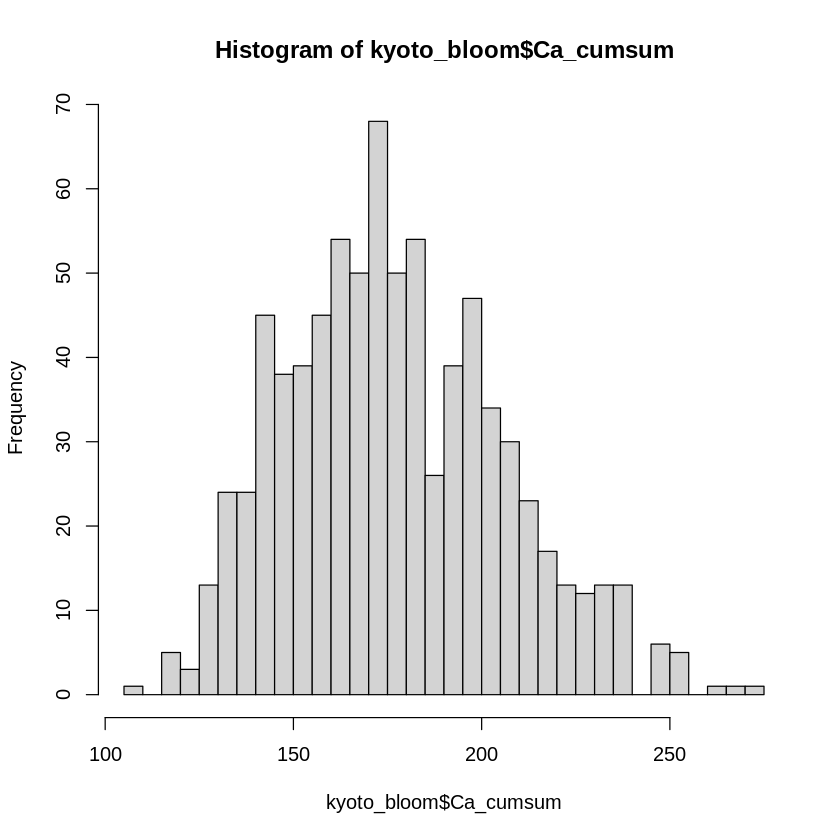

In [18]:
kyoto_bloom_idx <- (kyoto_complete2$is_bloom == 1) 
kyoto_bloom <- kyoto_complete2[kyoto_bloom_idx, ] %>%
    mutate(tmean = (tmax + tmin)/2) 
kyoto_bloom$idx <- seq_len(nrow(kyoto_bloom))
# dim(kyoto_bloom)
# head(kyoto_bloom)

hist(kyoto_bloom$Ca_cumsum, breaks = 30)

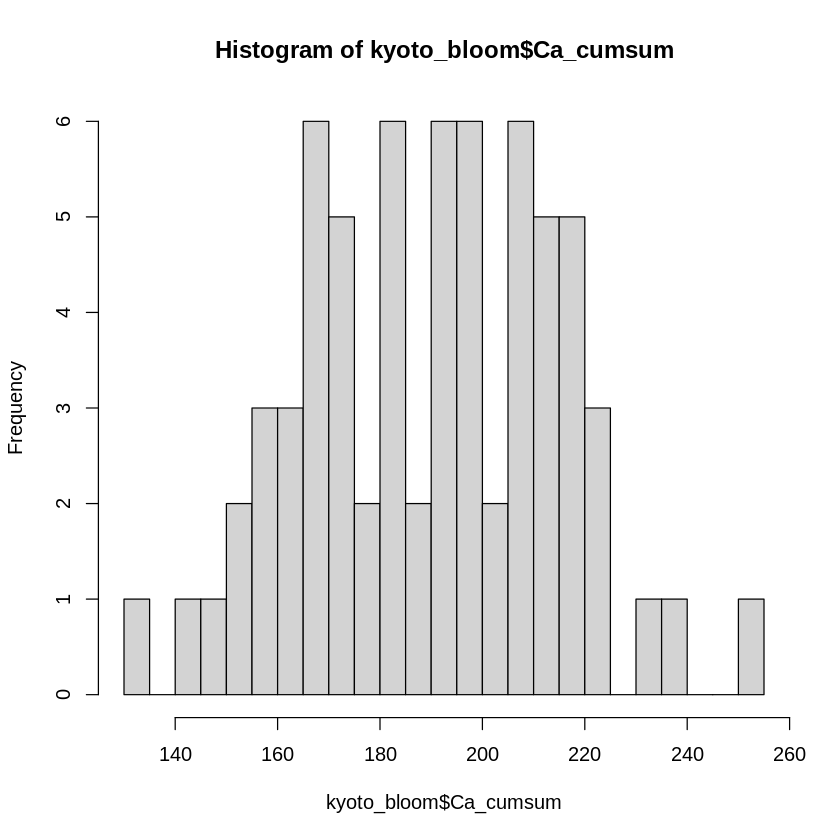

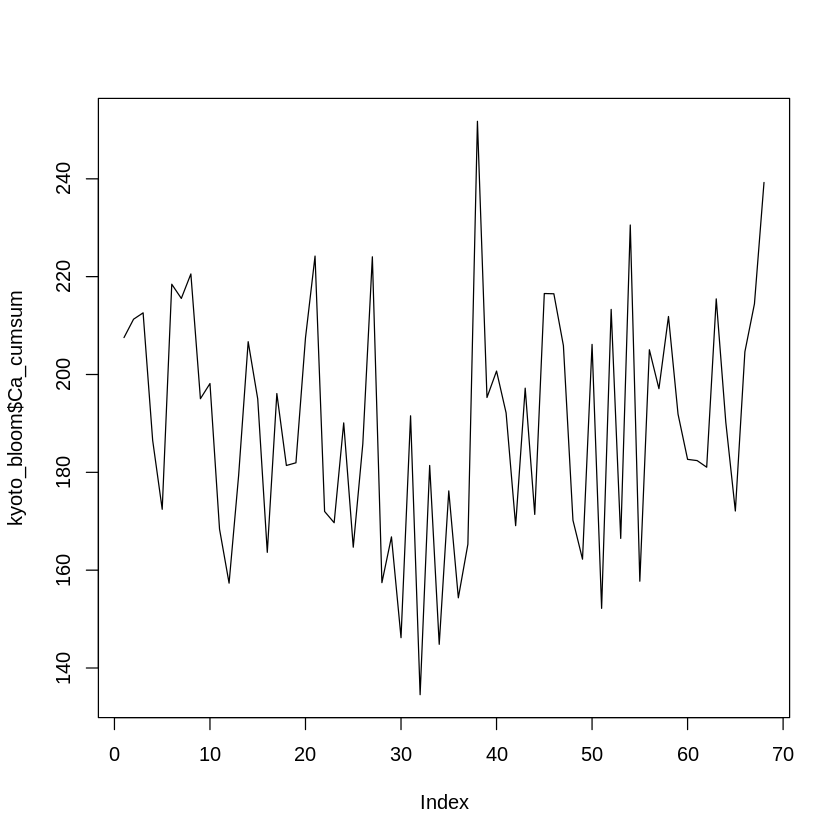

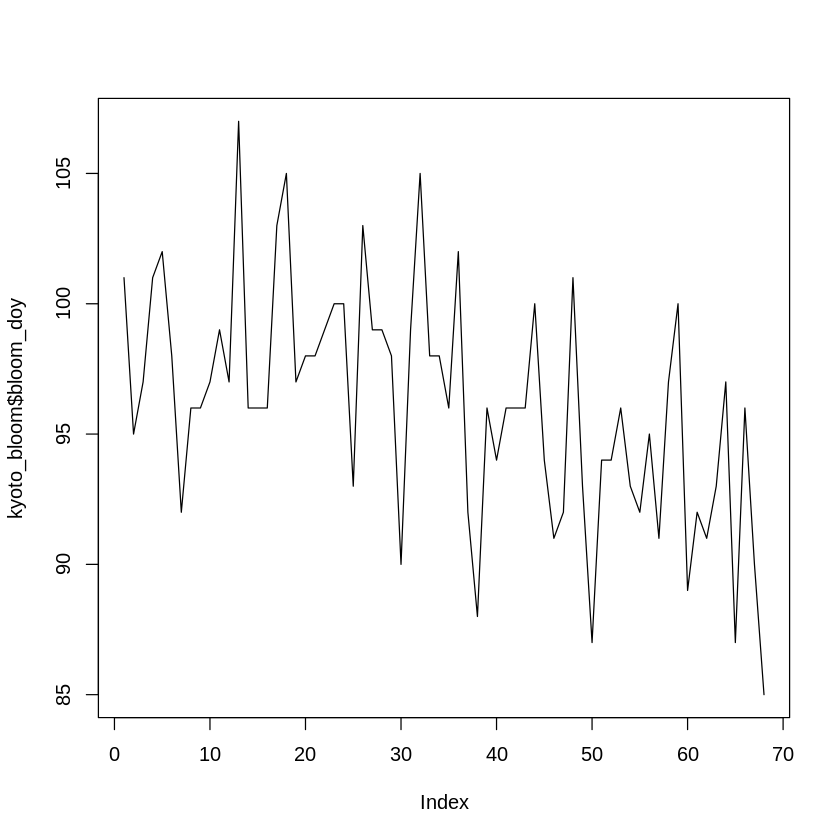

In [10]:
# kyoto_bloom_idx <- (kyoto_complete2$is_bloom == 1) & (kyoto_complete2$year > 1980)
# kk <- kyoto_complete2$is_bloom == 

kyoto_bloom_idx <- (kyoto_complete2$is_bloom == 1) 
kyoto_bloom <- kyoto_complete2[kyoto_bloom_idx, ] %>%
    mutate(tmean = (tmax + tmin)/2) %>%
    filter(name == "KYOTO")
kyoto_bloom$idx <- seq_len(nrow(kyoto_bloom))
# dim(kyoto_bloom)
# head(kyoto_bloom)

hist(kyoto_bloom$Ca_cumsum, breaks = 30)
plot(kyoto_bloom$Ca_cumsum, type = "l")
plot(kyoto_bloom$bloom_doy, type = "l")

In [19]:
# kyoto_complete2[((140 > kyoto_complete2$Ca_cumsum) | (kyoto_complete2$Ca_cumsum > 250)) & (kyoto_complete2$is_bloom), ]
kyoto_out <- kyoto_complete2 %>% 
    filter(130 < Ca_cumsum & Ca_cumsum < 240)
write.csv(kyoto_out, "../outputs/A_outputs/A41_gdd_kyoto.csv", row.names = FALSE)

Loading required package: MASS


Attaching package: ‘MASS’


The following object is masked from ‘package:dplyr’:

    select


Loading required package: nlme


Attaching package: ‘nlme’


The following object is masked from ‘package:dplyr’:

    collapse




,Est.,St.Err.,t value,CI(95%).l,CI(95%).u
slope1,0.35495,0.068498,5.1818,0.22069,0.48920
slope2,-0.35382,0.042709,-8.2846,-0.43753,-0.27012


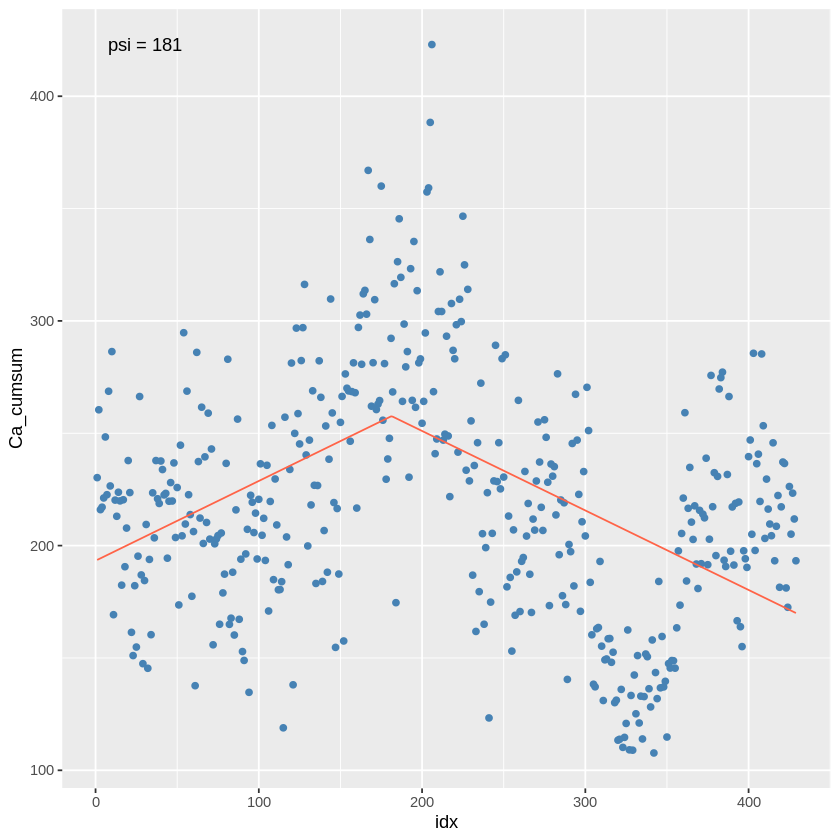

In [12]:
# perform segmented regression to find the break point.
library(segmented)
kyoto_glm <- glm(formula = Ca_cumsum ~ idx, data = kyoto_bloom, family = gaussian)
# summary(kyoto_glm)
kyoto_seg <- segmented::segmented(kyoto_glm, seg.Z = ~idx)

slope(kyoto_seg)
psi <- round(kyoto_seg$psi[, "Est."])

kyoto_fitted <- fitted(kyoto_seg)
kyoto_model <- data.frame(idx = kyoto_bloom$idx, Ca_cumsum = kyoto_fitted)

p <- ggplot(data = kyoto_bloom, aes(x = idx, y = Ca_cumsum))
p <- p + geom_point(color = "steelblue")
p <- p + geom_line(data = kyoto_model, aes(x = idx, y = Ca_cumsum), colour = "tomato")
p <- p + annotate("text", x = 30, y = max(kyoto_bloom$Ca_cumsum), label = paste0("psi = ", psi))
p